## Implementation of Actor-critic with GAE
### *heavily inpsired by OpenAI code
This code makes use of a Memory to store various values, this makes it easier to pass the values, but also for the GAE calculation. For actor-critic updates the episode does not have to end, and if working with env like cartpole, a batch can contain several episodes. This code also does not share weights between actor and critic contrary to the "simple" implementation found in this repository. 

Also please note that parameters have not been optimized. The parameters and environment are chosen for simplicity.

In [1]:
import numpy as np
import scipy.signal
import gym
from torch.optim import Adam
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import matplotlib.pyplot as plt

In [2]:
class MLPActorCritic(nn.Module):


    def __init__(self, observation_space, action_space, 
                 hidden_sizes = (64,64), activation=nn.Tanh):
        super().__init__()

        obs_dim = observation_space.shape[0]

        # policy builder depends on action space
        """if isinstance(action_space, Box):
            self.pi = MLPGaussianActor(obs_dim, action_space.shape[0], hidden_sizes, activation)
        elif isinstance(action_space, Discrete):"""
        self.pi = MLPCategoricalActor(obs_dim, action_space.n, hidden_sizes, activation) #actor

        # build value function
        self.v  = MLPCritic(obs_dim, hidden_sizes, activation) #critic

    def step(self, obs):
        with torch.no_grad():
            pi = self.pi._distribution(obs)
            a = pi.sample()
            logp_a = self.pi._log_prob_from_distribution(pi, a)
            v = self.v(obs)
        return a.numpy(), v.numpy(), logp_a.numpy()

    def act(self, obs):
        return self.step(obs)[0]
    
class MLPCritic(nn.Module):

    def __init__(self, obs_dim, hidden_sizes, activation):
        super().__init__()
        self.v_net = mlp([obs_dim] + list(hidden_sizes) + [1], activation)

    def forward(self, obs):
        return torch.squeeze(self.v_net(obs), -1)
    
class MLPCategoricalActor(nn.Module):
    
    def __init__(self, obs_dim, act_dim, hidden_sizes, activation):
        super().__init__()
        self.logits_net = mlp([obs_dim] + list(hidden_sizes) + [act_dim], activation)

    def _distribution(self, obs):
        logits = self.logits_net(obs)
        return Categorical(logits=logits)

    def _log_prob_from_distribution(self, pi, act):
        return pi.log_prob(act)
    
    def forward(self, obs, act=None):
        # Produce action distributions for given observations, and 
        # optionally compute the log likelihood of given actions under
        # those distributions.
        pi = self._distribution(obs)
        logp_a = None
        if act is not None:
            logp_a = self._log_prob_from_distribution(pi, act)
        return pi, logp_a

In [3]:
def mlp(sizes, activation, output_activation=nn.Identity):
    layers = []
    for j in range(len(sizes)-1):
        act = activation if j < len(sizes)-2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    return nn.Sequential(*layers)

def combined_shape(length, shape=None):
    if shape is None:
        return (length,)
    return (length, shape) if np.isscalar(shape) else (length, *shape)

def discount_cumsum(x, discount):
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]

In [4]:
class Memory:
    # make memory
    def __init__(self, obs_dim, act_dim, size, gamma, lambda_gae):
        # save obs, act, adv, rew, rewtg
        self.obs_buf = np.zeros(combined_shape(size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros(combined_shape(size, act_dim), dtype=np.float32)
        self.adv_buf = np.zeros(size, dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.rewtg_buf = np.zeros(size, dtype=np.float32)
        self.val_buf = np.zeros(size, dtype=np.float32)
        # define gamma and lambda
        self.gamma, self.lambda_gae = gamma, lambda_gae
        #define pointers to keep track of beginning and ending of episode (used for GAE)
        self.ptr, self.path_start_idx, self.max_size = 0, 0, size
        
    # make functions to: store, calculate gae and get data-----------------------------------------------------------
    def store(self, obs, act, rew, val):#, logp):
        assert self.ptr < self.max_size     # make sure that there is enough room in memory
        self.obs_buf[self.ptr] = obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.val_buf[self.ptr] = val
        self.ptr += 1 # move pointer
        
    def GAE(self, last_val=0):
        # take only steps that are part of that episode
        path_slice = slice(self.path_start_idx, self.ptr) # the indices
        rews = np.append(self.rew_buf[path_slice], last_val)
        vals = np.append(self.val_buf[path_slice], last_val)
        
        # GAE-Lambda advantage calculation
        deltas = rews[:-1] + self.gamma * vals[1:] - vals[:-1]
        self.adv_buf[path_slice] = discount_cumsum(deltas, self.gamma * self.lambda_gae)
        
        # reward to go = targets for value function
        self.rewtg_buf[path_slice] = discount_cumsum(rews, self.gamma)[:-1] 
        
        self.path_start_idx = self.ptr # reset pointer
        
    def get(self): # get all data in memory
        assert self.ptr == self.max_size   
        self.ptr, self.path_start_idx = 0, 0 # reset pointers
        
        # advantage normalization (usually mean&std of all parallell workers)
        self.adv_buf = (self.adv_buf - np.mean(self.adv_buf)) / np.std(self.adv_buf)
        
        # return data in seperate tensors
        data = dict(obs=self.obs_buf, act=self.act_buf, rewtg=self.rewtg_buf,
                    adv=self.adv_buf)
        return {k: torch.as_tensor(v, dtype=torch.float32) for k,v in data.items()}
        

In [8]:
def vpg(env_fn, actor_critic=MLPActorCritic, hidden_sizes=(64,64), gamma=0.99, 
        seed=0, steps_per_epoch=200, epochs=2, pi_lr=3e-4, vf_lr=1e-3, lambda_gae=0.97, 
        max_ep_len=200, activation=nn.Tanh):
    
    # Random seed
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Instantiate environment
    env = env_fn()
    obs_dim = env.observation_space.shape
    act_dim = env.action_space.shape
    
    # Create actor-critic module
    ac = actor_critic(env.observation_space, env.action_space, hidden_sizes, activation)
    
    # Set up optimizers for policy and value function
    pi_optimizer = Adam(ac.pi.parameters(), lr=pi_lr)
    vf_optimizer = Adam(ac.v.parameters(), lr=vf_lr)
    
    # Set up memory
    buf = Memory(obs_dim, act_dim, steps_per_epoch, gamma, lambda_gae)
    
    #--------------------------------------------------------------------------------------------------------------
    # Set up function for computing VPG policy loss
    def compute_loss_pi(data):
        obs, act, adv = data['obs'], data['act'], data['adv']

        # Policy loss
        pi, logp = ac.pi(obs, act)
        loss_pi = -(logp * adv).mean()

        return loss_pi
    
    # Set up function for computing value loss
    def compute_loss_v(data):
        obs, rewtg = data['obs'], data['rewtg']
        return ((ac.v(obs) - rewtg)**2).mean() # (values - reward to go) MSE
    

    # Set up function for updating pi and v
    def update():
        data = buf.get()

        # Train policy with a single step of gradient descent
        pi_optimizer.zero_grad()
        loss_pi = compute_loss_pi(data)
        loss_pi.backward()
        pi_optimizer.step()

        # Value function learning
        vf_optimizer.zero_grad()
        loss_v = compute_loss_v(data)
        loss_v.backward()
        vf_optimizer.step()
        
    #--------------------------------------------------------------------------------------------------------------    
    # Prepare for interaction with environment
    o = env.reset()
    ep_len = 0
    ep_rew = 0
    all_ep_rew, avg_rew = [], []

    # Main loop: collect experience in env and update/log each epoch
    for epoch in range(epochs):
        for t in range(steps_per_epoch):
            a, v, logp = ac.step(torch.as_tensor(o, dtype=torch.float32)) # get action based on initial obs

            next_o, r, d, _ = env.step(a) # get next obs
            ep_len += 1
            ep_rew += r
            
            # save and log
            buf.store(o, a, r, v) #, logp)
            
            # Update obs (critical!)
            o = next_o
            
            # keep track of where you are in episode/batch
            timeout = ep_len == max_ep_len #end of episode
            terminal = d or timeout #done or end of episode
            epoch_ended = t==steps_per_epoch-1 #end of an epoch when all steps used (when terminal continue)
            
            if terminal or epoch_ended: # only for these cases need to save next value & reset env
                #if epoch_ended and not(terminal):
                    #print('Warning: trajectory cut off by epoch at %d steps.'%ep_len, flush=True)
                    
                # if trajectory didn't reach terminal state, bootstrap value target
                if timeout or epoch_ended:
                    _, v, _ = ac.step(torch.as_tensor(o, dtype=torch.float32)) # get next value
                    all_ep_rew.append(ep_rew)
                else:
                    v = 0 # if terminal next value is 0
                    all_ep_rew.append(ep_rew)
                    
                buf.GAE(v) # calculate advantages using these values

                o, ep_len, ep_rew = env.reset(), 0, 0 # reset the env
                
        #keep track of average returns of batches/epochs
        avg_rew.append(np.mean(all_ep_rew))
        if epoch % 100 == 0:
            print("Avg rewards: ", np.mean(all_ep_rew))
            
        # Perform policy update, every time step
        update()
    return avg_rew

Avg rewards:  16.666666666666668
Avg rewards:  33.779264214046826
Avg rewards:  48.96467722289891
Avg rewards:  61.36595310907237
Avg rewards:  71.22557726465364
Avg rewards:  80.28846153846153
Avg rewards:  85.97997138769671
Avg rewards:  92.72486772486772
Avg rewards:  97.86194257788638
Avg rewards:  101.46396396396396
Avg rewards:  105.92592592592592
Avg rewards:  109.77068793619142
Avg rewards:  112.92900799247766
Avg rewards:  115.6958648288128
Avg rewards:  118.8295165394402
Avg rewards:  121.83441558441558
Avg rewards:  124.44617178390983
Avg rewards:  127.0825550989914
Avg rewards:  128.96527031865378
Avg rewards:  131.013094417643


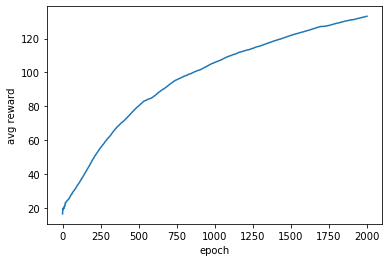

In [9]:
result = vpg(lambda : gym.make("CartPole-v0"), actor_critic=MLPActorCritic, hidden_sizes=(64,64), gamma=0.99, 
             seed=0, steps_per_epoch=200, epochs=2000, pi_lr=3e-4, vf_lr=1e-3, lambda_gae=0.97, 
             max_ep_len=200, activation=nn.Tanh)

plt.plot(result)
plt.xlabel("epoch")
plt.ylabel("avg reward")
plt.show()